In [1]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)
df_votes['vote'] = df_votes['vote'].replace({'Non-votant' : 'Nonvotant'})

In [3]:
#On récupère le groupe politique pour chaque député
groupe = df_votes[['idVotant', 'Groupe politique (complet)']].drop_duplicates()
groupe = groupe.set_index('idVotant')
groupe = groupe.rename(columns={'Groupe politique (complet)' : 'groupe'})
groupe = groupe.replace('Mouvement Démocrate (MoDem) et Démocrates apparentés', 'MoDem et Démocrates apparentés')

# 1. Evolution des votes selon l'année

In [4]:
#On détermine d'abord le cluster de chaque député selon l'historique sur toute la période.
historique_vote = df_votes.copy()
historique_vote = historique_vote.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
#on remplace les NaN par de l'abstention (en confondant abstention et non-votant)
historique_vote = historique_vote.fillna('Non-votant')
historique_vote = pd.get_dummies(historique_vote, drop_first=True)

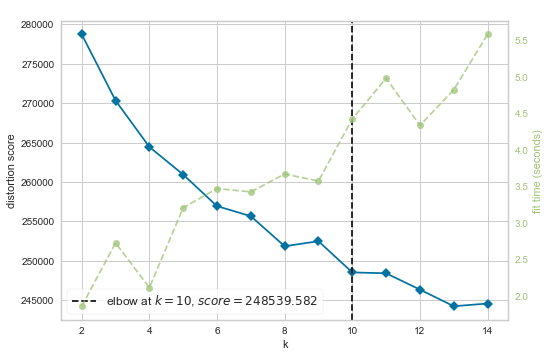

In [5]:
#on représente graphiquement la règle du coude pour déterminer le nombre de clusters à retenir
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), metric='distortion', title=' ') 
visualizer.fit(historique_vote)       
visualizer.show(outpath='regle_coude.pdf') 

In [6]:
#La règle du coude a déterminé qu'il faut choisir 7 clusters : 
cluster_votes = historique_vote.copy() 

N_CLUSTERS = 7
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_votes)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_votes)
cluster_votes['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu
cluster = cluster_votes[['cluster']]

In [7]:
#on associe une couleur à un parti (dans l'ordre politique, de bleu à rouge)
color_dict = {'Les Républicains' : 'b',
              'Libertés et Territoires' : 'dodgerblue',
              'UDI et Indépendants' : 'cornflowerblue',
              'Agir ensemble' : 'paleturquoise',
              'MoDem et Démocrates apparentés' : 'gold',
              'La République en Marche' : 'darkorange', 
              'Gauche démocrate et républicaine' : 'tomato', 
              'Socialistes et apparentés' : 'r',
              'La France insoumise' : 'darkred',
              'Non inscrit' : 'silver', 
              'Député fictif' : 'black'}

## Votes de 2017

Variance: [0.06714825 0.06045392 0.03544268 0.02378676 0.02174128 0.01855658
 0.01590059 0.0151084  0.01396956 0.0117533 ]
Variance totale: 0.28386132750738885


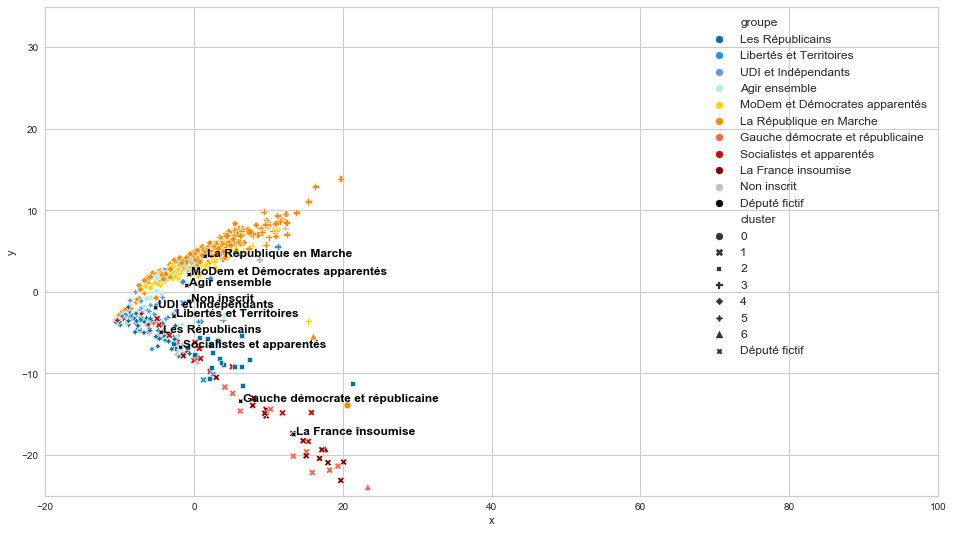

In [8]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()
votes_2017 = votes_2017.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
votes_2017 = votes_2017.fillna('Nonvotant')
votes_2017.index.name = None
votes_2017.columns.name = None
votes_2017 = pd.get_dummies(votes_2017, drop_first=True)

cluster_2017 = votes_2017.copy() 
cluster_2017[['cluster']] = cluster
cluster_2017[['groupe']] = groupe
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2017.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2017.groupe]
cluster_2017['labels'] = labels
cluster_2017_acp = cluster_2017.drop(['cluster','labels','groupe'], axis=1)

votes_2017_transform = StandardScaler().fit_transform(cluster_2017_acp)
pca = PCA(n_components=10).fit(votes_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]
y_2017 = -(y_2017)

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)
df_plot_2017 = pd.merge(df_plot_2017, cluster_2017[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2017[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2017 = df_plot_2017.append(dep_moyen)

plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                    hue_order=ordre_groupe, style_order = ordre_cluster)

#pour nommer les points des députés fictifs
for line in dep_moyen.index:
     plt.text(df_plot_2017.x[line]+0.3, df_plot_2017.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right', fontsize=12)
plt.savefig('votes_2017.png')
plt.savefig('2votes_2017.png')
plt.savefig('3votes_2017.png')
plt.savefig('4votes_2017.png')
plt.savefig('5votes_2017.png')
plt.savefig('acp_votes_2017.pdf')

## Votes de 2018

Variance: [0.05682341 0.04623219 0.02860758 0.02736498 0.01978973 0.01753787
 0.01704218 0.01471771 0.01327206 0.01226869]
Variance totale: 0.2536564061039585


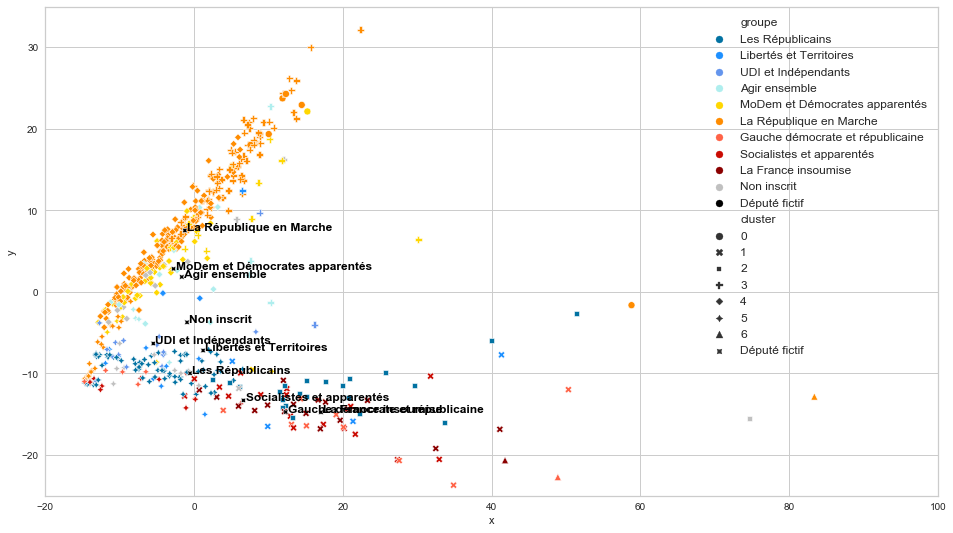

In [9]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()
votes_2018 = votes_2018.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
votes_2018 = votes_2018.fillna('Nonvotant')
votes_2018.index.name = None
votes_2018.columns.name = None
votes_2018 = pd.get_dummies(votes_2018, drop_first=True)

cluster_2018 = votes_2018.copy() 
cluster_2018[['cluster']] = cluster
cluster_2018[['groupe']] = groupe
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2018.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2018.groupe]
cluster_2018['labels'] = labels
cluster_2018_acp = cluster_2018.drop(['cluster','labels','groupe'], axis=1)

votes_2018_transform = StandardScaler().fit_transform(cluster_2018_acp)
pca = PCA(n_components=10).fit(votes_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)
df_plot_2018 = pd.merge(df_plot_2018, cluster_2018[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2018[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2018 = df_plot_2018.append(dep_moyen)

plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                    hue_order=ordre_groupe, style_order = ordre_cluster)

#pour nommer les points des députés fictifs
for line in dep_moyen.index:
     plt.text(df_plot_2018.x[line]+0.3, df_plot_2018.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right', fontsize=12)
plt.savefig('votes_2018.png')
plt.savefig('2votes_2018.png')
plt.savefig('3votes_2018.png')
plt.savefig('4votes_2018.png')
plt.savefig('5votes_2018.png')
plt.savefig('acp_votes_2018.pdf')

## Votes de 2019

Variance: [0.05660063 0.04226398 0.02389554 0.02358514 0.01872004 0.01525418
 0.01477866 0.0144707  0.01274731 0.01161413]
Variance totale: 0.23393031901418784


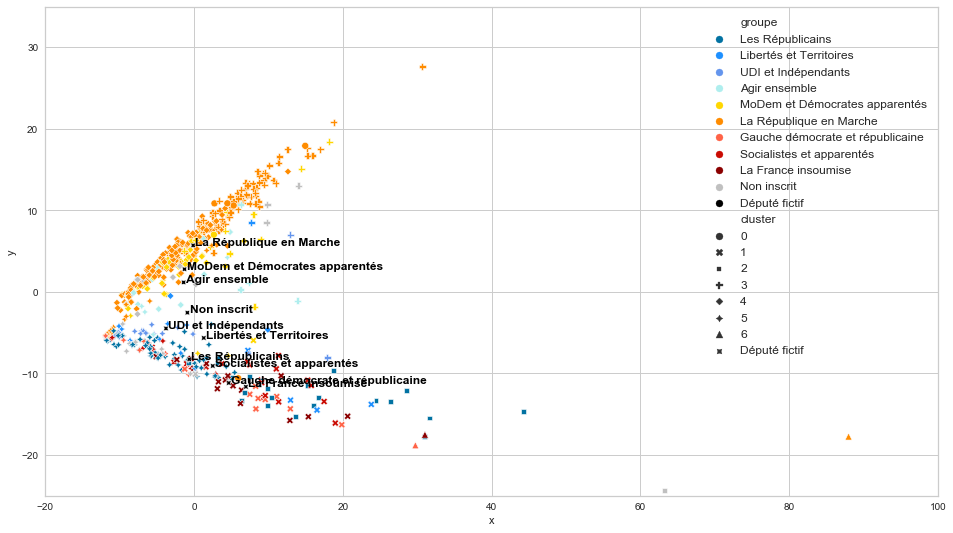

In [10]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()
votes_2019 = votes_2019.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
votes_2019 = votes_2019.fillna('Nonvotant')
votes_2019.index.name = None
votes_2019.columns.name = None
votes_2019 = pd.get_dummies(votes_2019, drop_first=True)

cluster_2019 = votes_2019.copy() 
cluster_2019[['cluster']] = cluster
cluster_2019[['groupe']] = groupe
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2019.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2019.groupe]
cluster_2019['labels'] = labels
cluster_2019_acp = cluster_2019.drop(['cluster','labels','groupe'], axis=1)

votes_2019_transform = StandardScaler().fit_transform(cluster_2019_acp)
pca = PCA(n_components=10).fit(votes_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)
df_plot_2019 = pd.merge(df_plot_2019, cluster_2019[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2019[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2019 = df_plot_2019.append(dep_moyen)

plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                    hue_order=ordre_groupe, style_order = ordre_cluster)

#pour nommer les points des députés fictifs
for line in dep_moyen.index:
     plt.text(df_plot_2019.x[line]+0.3, df_plot_2019.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right', fontsize=12)
plt.savefig('votes_2019.png')
plt.savefig('2votes_2019.png')
plt.savefig('3votes_2019.png')
plt.savefig('4votes_2019.png')
plt.savefig('5votes_2019.png')
plt.savefig('acp_votes_2019.pdf')

## Votes de 2020

Variance: [0.06684645 0.05397193 0.02905083 0.02027739 0.01654853 0.01578306
 0.01468717 0.01430934 0.01350749 0.01185199]
Variance totale: 0.25683419864115026


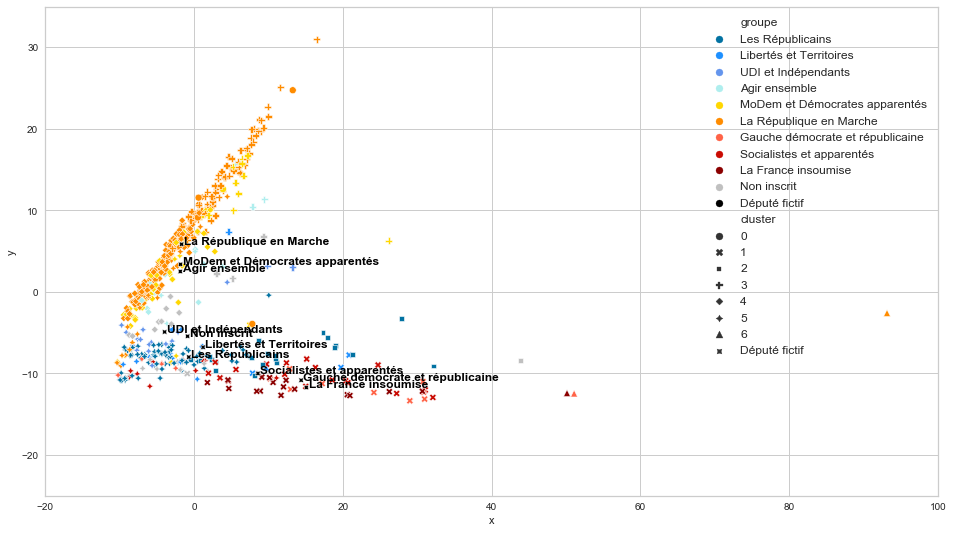

In [11]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()
votes_2020 = votes_2020.pivot(index = 'idVotant', columns = 'idScrutin', values = 'vote')
votes_2020 = votes_2020.fillna('Nonvotant')
votes_2020.index.name = None
votes_2020.columns.name = None
votes_2020 = pd.get_dummies(votes_2020, drop_first=True)

cluster_2020 = votes_2020.copy() 
cluster_2020[['cluster']] = cluster
cluster_2020[['groupe']] = groupe
        
###ACP

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(cluster_2020.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in cluster_2020.groupe]
cluster_2020['labels'] = labels
cluster_2020_acp = cluster_2020.drop(['cluster','labels','groupe'], axis=1)

votes_2020_transform = StandardScaler().fit_transform(cluster_2020_acp)
pca = PCA(n_components=10).fit(votes_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(votes_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)
df_plot_2020 = pd.merge(df_plot_2020, cluster_2020[['cluster']].reset_index(drop=True), left_index=True, right_index=True)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2020[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2020 = df_plot_2020.append(dep_moyen)

plt.figure(figsize=(16,9))
plt.ylim([-25, 35])
plt.xlim([-20, 100])
#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                    hue_order=ordre_groupe, style_order = ordre_cluster)

#pour nommer les points des députés fictifs
for line in dep_moyen.index:
     plt.text(df_plot_2020.x[line]+0.3, df_plot_2020.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.legend(loc='upper right', fontsize=12)
plt.savefig('votes_2020.png')
plt.savefig('2votes_2020.png')
plt.savefig('3votes_2020.png')
plt.savefig('4votes_2020.png')
plt.savefig('5votes_2020.png')
plt.savefig('acp_votes_2020.pdf')

In [12]:
#on réalise un gif avec les graphiques précédents
import imageio 
images = [] 
filenames=['votes_2017.png', '2votes_2017.png', '3votes_2017.png', '4votes_2017.png', '5votes_2017.png',
           'votes_2018.png', '2votes_2018.png', '3votes_2018.png', '4votes_2018.png', '5votes_2018.png',
           'votes_2019.png', '2votes_2019.png', '3votes_2019.png', '4votes_2019.png', '5votes_2019.png',
           'votes_2020.png', '2votes_2020.png', '3votes_2020.png', '4votes_2020.png', '5votes_2020.png'] 
for filename in filenames: 
    images.append(imageio.imread(filename)) 
    imageio.mimsave('votes.gif', images)
plt.clf()
from IPython.display import Image
display(Image(url='votes.gif'))

<Figure size 576x396 with 0 Axes>

# 2. Evolution des indices

In [13]:
#Indices
proportion_vote = pd.read_csv('proportion_vote.csv', index_col=0)

indice_accord = pd.read_csv('indice_accord.csv', index_col=0)
indice_accord = indice_accord[['idVotant', 'IndiceAccord']]
indice_accord = indice_accord.rename(columns={'IndiceAccord' : 'indice_accord'})

abstention = df_votes.groupby('idVotant').count()
abstention['taux_abstention'] = (1 - abstention['idScrutin']/3117)*100
abstention = abstention[['taux_abstention']]

df_indices = proportion_vote.merge(indice_accord, on='idVotant', how='left')
df_indices = df_indices.merge(abstention, on='idVotant', how='left')
df_indices = df_indices.set_index('idVotant')

In [14]:
#on implémente un modèle k-means avec comme variables les indices créés ci-dessus
cluster_indices = df_indices.copy()

N_CLUSTERS = 2
clustering = KMeans(n_clusters=N_CLUSTERS)
clustering.fit(cluster_indices)

#on détermine ensuite dans quel cluster chaque individu de df_cluster sera affecté :
pred = clustering.predict(cluster_indices)
df_indices['cluster'] = pred #on ajoute une colonne au df, qui indique le numéro du cluster auquel appartient chaque individu

### 2017

In [15]:
votes_2017 = df_votes[df_votes.date_scrutin < "2018-01-01"].copy()

#taux de abstention
nb_votes_2017 = votes_2017['idScrutin'].nunique()
abstention_2017 = votes_2017.groupby('idVotant').count()
abstention_2017['taux_abstention'] = (1 - abstention_2017['idScrutin']/(nb_votes_2017))*100
abstention_2017 = abstention_2017[['taux_abstention']]
abstention_2017.index.name = 'idVotant'

#proportion vote
avis_votant_2017 = pd.DataFrame(votes_2017.groupby(['idVotant']).vote.value_counts())
avis_votant_2017 = avis_votant_2017.rename(columns={'vote':'nombre'})
total_votant_2017 = votes_2017.groupby(['idVotant']).vote.count()
proportion_2017 = pd.DataFrame({'Proportion' : np.round(avis_votant_2017['nombre'].div(total_votant_2017)*100, decimals=2)})
proportion_2017 = proportion_2017.unstack()
proportion_2017.columns = proportion_2017.columns.droplevel()
proportion_2017 = proportion_2017.drop('Nonvotant', axis=1)
proportion_2017 = proportion_2017.fillna(0)
proportion_2017.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2017.groupby('idVotant')['organeRefGroupe'].unique())
df_2017 = votes_2017[((votes_2017.vote == 'Pour') & (votes_2017.resultat == 'adopté')) | ((votes_2017.vote == 'Contre') & (votes_2017.resultat == 'rejeté'))]
accord_votant = df_2017.idVotant.value_counts() 
total_votant = votes_2017.idVotant.value_counts()
indice_accord_2017 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2017.index = indice_accord_2017.index.rename('idVotant')
indice_accord_2017.index.name = 'idVotant'


#df final
indices_2017 = proportion_2017.merge(indice_accord_2017, on='idVotant', how='left')
indices_2017 = indices_2017.merge(abstention_2017, on='idVotant', how='left')
indices_2017 = indices_2017.fillna(0)

Variance: [0.7278869  0.20174624 0.06541455 0.00495231]
Variance totale: 1.0


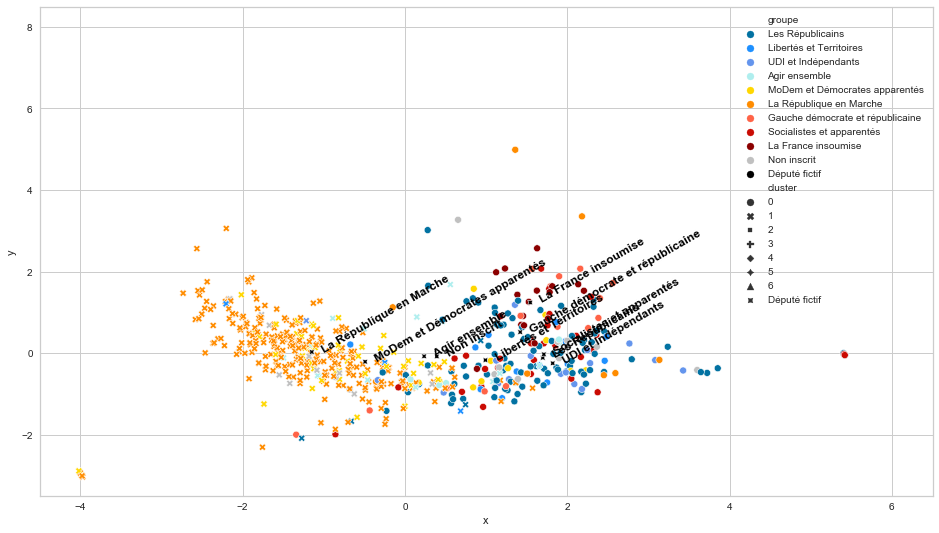

In [16]:
indices_cluster = df_indices[['cluster']]
indices_cluster.index.name = 'idVotant'
indices_2017 = indices_2017.merge(indices_cluster, on='idVotant', how='left')
indices_2017 = indices_2017.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2017.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2017.groupe]
indices_2017['labels'] = labels
indices_2017_acp = indices_2017.drop(['cluster','labels','groupe'], axis=1)

indices_2017_transform = StandardScaler().fit_transform(indices_2017_acp)
pca = PCA(n_components=4).fit(indices_2017_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2017_transform)
x_2017 = resultats_reduced[:, 0]
y_2017 = resultats_reduced[:, 1]

df_plot_2017 = pd.DataFrame(dict(x=x_2017, y=y_2017, label=labels))
df_plot_2017.index = indices_2017.index
df_plot_2017 = df_plot_2017.merge(indices_2017[['cluster']], on='idVotant', how='left')
df_plot_2017['groupe'] = df_plot_2017['label'].replace(labels_to_groupe)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2017[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2017 = df_plot_2017.append(dep_moyen)

plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])

#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2017, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                   style_order=ordre_cluster, hue_order=ordre_groupe)

for line in dep_moyen.index:
     plt.text(df_plot_2017.x[line]+0.1, df_plot_2017.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2017.png')
plt.savefig('2indices_2017.png')
plt.savefig('3indices_2017.png')
plt.savefig('4indices_2017.png')

### 2018

In [17]:
votes_2018 = df_votes[(df_votes.date_scrutin >= "2018-01-01") & (df_votes.date_scrutin < "2019-01-01")].copy()

#taux de abstention
nb_votes_2018 = votes_2018['idScrutin'].nunique()
abstention_2018 = votes_2018.groupby('idVotant').count()
abstention_2018['taux_abstention'] = (1 - abstention_2018['idScrutin']/(nb_votes_2018))*100
abstention_2018 = abstention_2018[['taux_abstention']]
abstention_2018.index.name = 'idVotant'

#proportion vote
avis_votant_2018 = pd.DataFrame(votes_2018.groupby(['idVotant']).vote.value_counts())
avis_votant_2018 = avis_votant_2018.rename(columns={'vote':'nombre'})
total_votant_2018 = votes_2018.groupby(['idVotant']).vote.count()
proportion_2018 = pd.DataFrame({'Proportion' : np.round(avis_votant_2018['nombre'].div(total_votant_2018)*100, decimals=2)})
proportion_2018 = proportion_2018.unstack()
proportion_2018.columns = proportion_2018.columns.droplevel()
proportion_2018 = proportion_2018.drop('Nonvotant', axis=1)
proportion_2018 = proportion_2018.fillna(0)
proportion_2018.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2018.groupby('idVotant')['organeRefGroupe'].unique())
df_2018 = votes_2018[((votes_2018.vote == 'Pour') & (votes_2018.resultat == 'adopté')) | ((votes_2018.vote == 'Contre') & (votes_2018.resultat == 'rejeté'))]
accord_votant = df_2018.idVotant.value_counts() 
total_votant = votes_2018.idVotant.value_counts()
indice_accord_2018 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2018.index = indice_accord_2018.index.rename('idVotant')
indice_accord_2018.index.name = 'idVotant'


#df final
indices_2018 = proportion_2018.merge(indice_accord_2018, on='idVotant', how='left')
indices_2018 = indices_2018.merge(abstention_2018, on='idVotant', how='left')
indices_2018 = indices_2018.fillna(0)

Variance: [0.73834119 0.21813581 0.03900146 0.00452154]
Variance totale: 0.9999999999999999


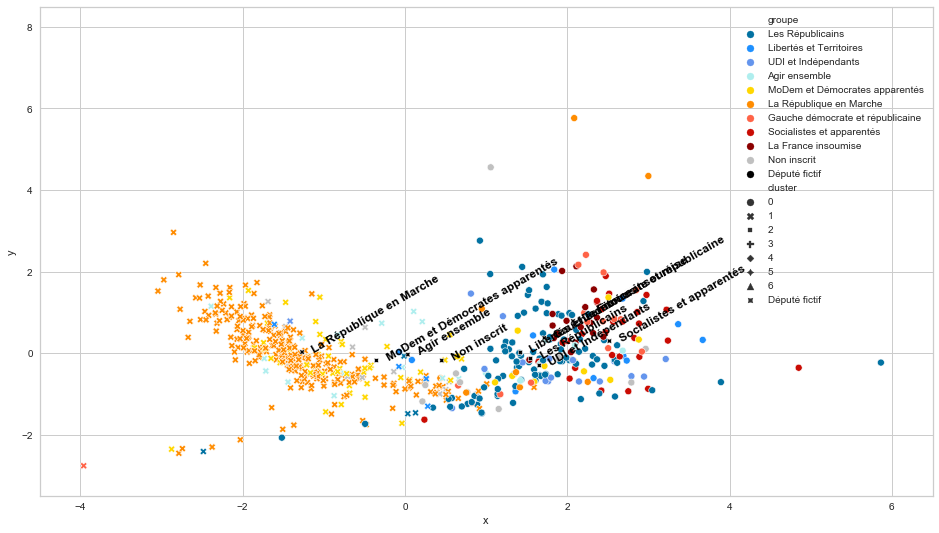

In [18]:
indices_cluster = df_indices[['cluster']]
indices_cluster.index.name = 'idVotant'
indices_2018 = indices_2018.merge(indices_cluster, on='idVotant', how='left')
indices_2018 = indices_2018.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2018.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2018.groupe]
indices_2018['labels'] = labels
indices_2018_acp = indices_2018.drop(['cluster','labels','groupe'], axis=1)

indices_2018_transform = StandardScaler().fit_transform(indices_2018_acp)
pca = PCA(n_components=4).fit(indices_2018_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2018_transform)
x_2018 = resultats_reduced[:, 0]
y_2018 = resultats_reduced[:, 1]

df_plot_2018 = pd.DataFrame(dict(x=x_2018, y=y_2018, label=labels))
df_plot_2018.index = indices_2018.index
df_plot_2018 = df_plot_2018.merge(indices_2018[['cluster']], on='idVotant', how='left')
df_plot_2018['groupe'] = df_plot_2018['label'].replace(labels_to_groupe)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2018[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2018 = df_plot_2018.append(dep_moyen)


plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])

#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2018, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                   style_order=ordre_cluster, hue_order=ordre_groupe)

for line in dep_moyen.index:
     plt.text(df_plot_2018.x[line]+0.1, df_plot_2018.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2018.png')
plt.savefig('2indices_2018.png')
plt.savefig('3indices_2018.png')
plt.savefig('4indices_2018.png')

### 2019

In [19]:
votes_2019 = df_votes[(df_votes.date_scrutin >= "2019-01-01") & (df_votes.date_scrutin < "2020-01-01")].copy()

#taux de abstention
nb_votes_2019 = votes_2019['idScrutin'].nunique()
abstention_2019 = votes_2019.groupby('idVotant').count()
abstention_2019['taux_abstention'] = (1 - abstention_2019['idScrutin']/(nb_votes_2019))*100
abstention_2019 = abstention_2019[['taux_abstention']]
abstention_2019.index.name = 'idVotant'

#proportion vote
avis_votant_2019 = pd.DataFrame(votes_2019.groupby(['idVotant']).vote.value_counts())
avis_votant_2019 = avis_votant_2019.rename(columns={'vote':'nombre'})
total_votant_2019 = votes_2019.groupby(['idVotant']).vote.count()
proportion_2019 = pd.DataFrame({'Proportion' : np.round(avis_votant_2019['nombre'].div(total_votant_2019)*100, decimals=2)})
proportion_2019 = proportion_2019.unstack()
proportion_2019.columns = proportion_2019.columns.droplevel()
proportion_2019 = proportion_2019.drop('Nonvotant', axis=1)
proportion_2019 = proportion_2019.fillna(0)
proportion_2019.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2019.groupby('idVotant')['organeRefGroupe'].unique())
df_2019 = votes_2019[((votes_2019.vote == 'Pour') & (votes_2019.resultat == 'adopté')) | ((votes_2019.vote == 'Contre') & (votes_2019.resultat == 'rejeté'))]
accord_votant = df_2019.idVotant.value_counts() 
total_votant = votes_2019.idVotant.value_counts()
indice_accord_2019 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2019.index = indice_accord_2019.index.rename('idVotant')
indice_accord_2019.index.name = 'idVotant'


#df final
indices_2019 = proportion_2019.merge(indice_accord_2019, on='idVotant', how='left')
indices_2019 = indices_2019.merge(abstention_2019, on='idVotant', how='left')
indices_2019 = indices_2019.fillna(0)

Variance: [0.68435533 0.20948705 0.09952557 0.00663204]
Variance totale: 1.0000000000000002


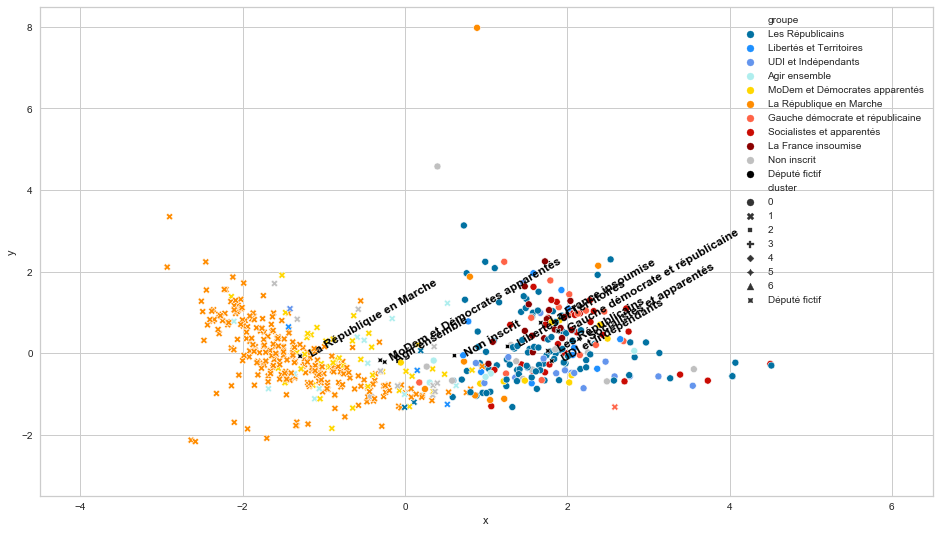

In [20]:
indices_cluster = df_indices[['cluster']]
indices_cluster.index.name = 'idVotant'
indices_2019 = indices_2019.merge(indices_cluster, on='idVotant', how='left')
indices_2019 = indices_2019.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2019.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2019.groupe]
indices_2019['labels'] = labels
indices_2019_acp = indices_2019.drop(['cluster','labels','groupe'], axis=1)

indices_2019_transform = StandardScaler().fit_transform(indices_2019_acp)
pca = PCA(n_components=4).fit(indices_2019_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2019_transform)
x_2019 = resultats_reduced[:, 0]
y_2019 = resultats_reduced[:, 1]

df_plot_2019 = pd.DataFrame(dict(x=x_2019, y=y_2019, label=labels))
df_plot_2019.index = indices_2019.index
df_plot_2019 = df_plot_2019.merge(indices_2019[['cluster']], on='idVotant', how='left')
df_plot_2019['groupe'] = df_plot_2019['label'].replace(labels_to_groupe)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2019[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2019 = df_plot_2019.append(dep_moyen)


plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])

#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2019, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                   style_order=ordre_cluster, hue_order=ordre_groupe)

for line in dep_moyen.index:
     plt.text(df_plot_2019.x[line]+0.1, df_plot_2019.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2019.png')
plt.savefig('2indices_2019.png')
plt.savefig('3indices_2019.png')
plt.savefig('4indices_2019.png')

### 2020

In [21]:
votes_2020 = df_votes[df_votes.date_scrutin >= "2020-01-01"].copy()

#taux de abstention
nb_votes_2020 = votes_2020['idScrutin'].nunique()
abstention_2020 = votes_2020.groupby('idVotant').count()
abstention_2020['taux_abstention'] = (1 - abstention_2020['idScrutin']/(nb_votes_2020))*100
abstention_2020 = abstention_2020[['taux_abstention']]
abstention_2020.index.name = 'idVotant'

#proportion vote
avis_votant_2020 = pd.DataFrame(votes_2020.groupby(['idVotant']).vote.value_counts())
avis_votant_2020 = avis_votant_2020.rename(columns={'vote':'nombre'})
total_votant_2020 = votes_2020.groupby(['idVotant']).vote.count()
proportion_2020 = pd.DataFrame({'Proportion' : np.round(avis_votant_2020['nombre'].div(total_votant_2020)*100, decimals=2)})
proportion_2020 = proportion_2020.unstack()
proportion_2020.columns = proportion_2020.columns.droplevel()
proportion_2020 = proportion_2020.drop('Nonvotant', axis=1)
proportion_2020 = proportion_2020.fillna(0)
proportion_2020.index.name = 'idVotant'


#indice accord
partis = pd.DataFrame(votes_2020.groupby('idVotant')['organeRefGroupe'].unique())
df_2020 = votes_2020[((votes_2020.vote == 'Pour') & (votes_2020.resultat == 'adopté')) | ((votes_2020.vote == 'Contre') & (votes_2020.resultat == 'rejeté'))]
accord_votant = df_2020.idVotant.value_counts() 
total_votant = votes_2020.idVotant.value_counts()
indice_accord_2020 = pd.DataFrame((np.round(accord_votant/total_votant*100, decimals=2))).rename(columns={'idVotant':'indice_accord'})
indice_accord_2020.index = indice_accord_2020.index.rename('idVotant')
indice_accord_2020.index.name = 'idVotant'


#df final
indices_2020 = proportion_2020.merge(indice_accord_2020, on='idVotant', how='left')
indices_2020 = indices_2020.merge(abstention_2020, on='idVotant', how='left')
indices_2020 = indices_2020.fillna(0)

Variance: [0.74232968 0.20485034 0.0492964  0.00352357]
Variance totale: 1.0


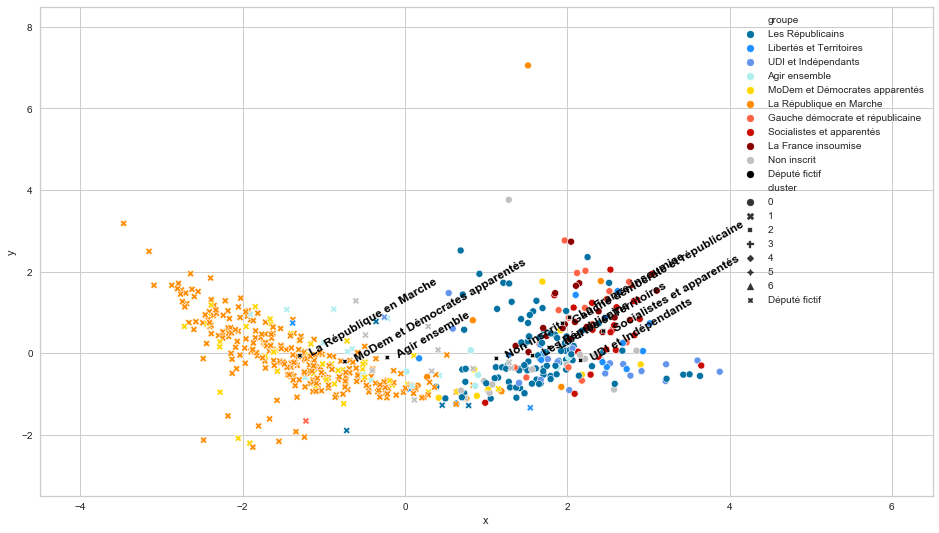

In [22]:
indices_cluster = df_indices[['cluster']]
indices_cluster.index.name = 'idVotant'
indices_2020 = indices_2020.merge(indices_cluster, on='idVotant', how='left')
indices_2020 = indices_2020.merge(groupe, on='idVotant', how='left')

groupe_to_labels = {groupe : idx for idx, groupe in enumerate(indices_2020.groupe.unique())}
labels_to_groupe = {label : groupe for groupe, label in groupe_to_labels.items()}
labels = [groupe_to_labels[groupe] for groupe in indices_2020.groupe]
indices_2020['labels'] = labels
indices_2020_acp = indices_2020.drop(['cluster','labels','groupe'], axis=1)

indices_2020_transform = StandardScaler().fit_transform(indices_2020_acp)
pca = PCA(n_components=4).fit(indices_2020_transform)

print('Variance:',pca.explained_variance_ratio_)
print('Variance totale:',pca.explained_variance_ratio_.sum())

resultats_reduced = pca.transform(indices_2020_transform)
x_2020 = resultats_reduced[:, 0]
y_2020 = resultats_reduced[:, 1]

df_plot_2020 = pd.DataFrame(dict(x=x_2020, y=y_2020, label=labels))
df_plot_2020.index = indices_2020.index
df_plot_2020 = df_plot_2020.merge(indices_2020[['cluster']], on='idVotant', how='left')
df_plot_2020['groupe'] = df_plot_2020['label'].replace(labels_to_groupe)

#on calcule le député fictif (moyen) par groupe
dep_moyen = df_plot_2020[['x', 'y', 'groupe']].groupby('groupe').mean()
dep_moyen['cluster'] = ['Député fictif']*10
dep_moyen['groupe'] = ['Député fictif']*10
dep_moyen['label'] = ['10']*10 #juste pour qu'il n'y ait pas de nan mais on ne s'en sert plus après

df_plot_2020 = df_plot_2020.append(dep_moyen)


plt.figure(figsize=(16,9))
plt.ylim([-3.5, 8.5])
plt.xlim([-4.5, 6.5])

#pour que la légende soit dans l'ordre des couleurs et des clusters :
ordre_groupe = ['Les Républicains', 'Libertés et Territoires', 'UDI et Indépendants', 'Agir ensemble',
                'MoDem et Démocrates apparentés', 'La République en Marche', 'Gauche démocrate et républicaine',
               'Socialistes et apparentés', 'La France insoumise', 'Non inscrit', 'Député fictif']
ordre_cluster = [0, 1, 2, 3, 4, 5, 6, 'Député fictif']

g = sns.scatterplot(data=df_plot_2020, x='x', y='y', style='cluster', hue='groupe', palette=color_dict, 
                   style_order=ordre_cluster, hue_order=ordre_groupe)

for line in dep_moyen.index:
     plt.text(df_plot_2020.x[line]+0.1, df_plot_2020.y[line], line, 
              horizontalalignment='left', size='medium', color='black', weight='semibold', rotation=30.)

plt.legend(loc='upper right')
plt.savefig('indices_2020.png')
plt.savefig('2indices_2020.png')
plt.savefig('3indices_2020.png')
plt.savefig('4indices_2020.png')

In [23]:
image = [] 
filename = ['indices_2017.png', '2indices_2017.png', '3indices_2017.png', '4indices_2017.png',
            'indices_2018.png', '2indices_2018.png', '3indices_2018.png', '4indices_2018.png',
            'indices_2019.png', '2indices_2019.png', '3indices_2019.png', '4indices_2019.png',
            'indices_2020.png', '2indices_2020.png', '3indices_2020.png', '4indices_2020.png'] 
for file in filename: 
    image.append(imageio.imread(file)) 
    imageio.mimsave('indices.gif', image)
from IPython.display import Image
display(Image(url='indices.gif'))